In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [5]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [6]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
63979,K.QVTTAENLKDQTVYIVLDKAEYLR.D,NDFVRLFKQVTTAEN,LDKAEYLRDMEANLL,VTTAENLKDQTVYIV,TVYIVLDKAEYLRDM,sp|O43913|ORC5_HUMAN,QVTTAENLKDQTVYIVLDKAEYLR,1


In [7]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [8]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(337179, 39) (337179, 30) (337179, 15) (337179, 15) (337179, 15) (337179, 15) (337179,)
(84295, 39) (84295, 30) (84295, 15) (84295, 15) (84295, 15) (84295, 15) (84295,)
(88998, 39) (88998, 30) (88998, 15) (88998, 15) (88998, 15) (88998, 15) (88998,)


# Train

In [9]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [10]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [11]:
pep = tf.keras.layers.Input(shape=((30,)))
input1_ = tf.keras.layers.Embedding(21, 32, input_length=30, mask_zero=True)(pep)
input1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input1_)

input2 = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
input3_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(n)
input3 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input3_)

c = tf.keras.layers.Input(shape=((15,)))
input4_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(c)
input4 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input4_)

m1 = tf.keras.layers.Input(shape=((15,)))
input5_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m1)
input5 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input5_)

m2 = tf.keras.layers.Input(shape=((15,)))
input6_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m2)
input6 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input6_)







cnn1 = tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same')(input1)
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(cnn1)
net_lstm_ = tf.keras.layers.Dense(16, activation='relu')(lstm1)
net_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_lstm_)

net_dense1_ = tf.keras.layers.Dense(32, activation='relu')(input2)
net_dense1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_dense1_)

cnn3 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input3)
digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn3)
net_n_ = tf.keras.layers.Dense(8, activation='relu')(digest_n)
net_n = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_n_)

cnn4 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input4)
digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn4)
net_c_ = tf.keras.layers.Dense(8, activation='relu')(digest_c)
net_c = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_c_)

cnn5 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input5)
digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn5)
net_m1_ = tf.keras.layers.Dense(8, activation='relu')(digest_m1)
net_m1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m1_)

cnn6 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input6)
digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn6)
net_m2_ = tf.keras.layers.Dense(8, activation='relu')(digest_m2)
net_m2 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m2_)








merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense1,
                                     net_n,
                                     net_c,
                                     net_m1,
                                     net_m2])

net1 = tf.keras.layers.Dense(64, activation='relu')(merge)
net1_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net1)
net3 = tf.keras.layers.Dense(32, activation='relu')(net1_drop)
net3_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net3)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net3_drop)

model_high = tf.keras.Model(inputs=[pep, input2,
                              n, c,
                              m1, m2],
                       outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [12]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=128,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
2635/2635 [==============================] - 138s 45ms/step - loss: 5.3948 - accuracy: 0.5155 - val_loss: 0.5869 - val_accuracy: 0.7172
Epoch 2/300
2635/2635 [==============================] - 115s 44ms/step - loss: 0.6496 - accuracy: 0.6717 - val_loss: 0.4373 - val_accuracy: 0.7981
Epoch 3/300
2635/2635 [==============================] - 114s 43ms/step - loss: 0.4646 - accuracy: 0.7825 - val_loss: 0.4022 - val_accuracy: 0.8107
Epoch 4/300
2635/2635 [==============================] - 114s 43ms/step - loss: 0.4165 - accuracy: 0.8044 - val_loss: 0.3874 - val_accuracy: 0.8180
Epoch 5/300
2635/2635 [==============================] - 116s 44ms/step - loss: 0.3977 - accuracy: 0.8147 - val_loss: 0.3791 - val_accuracy: 0.8210
Epoch 6/300
2635/2635 [==============================] - 117s 44ms/step - loss: 0.3893 - accuracy: 0.8199 - val_loss: 0.3739 - val_accuracy: 0.8242
Epoch 7/300
2635/2635 [==============================] - 116s 44ms/step - loss: 0.3822 - accuracy: 0.8222 - val_

2635/2635 [==============================] - 106s 40ms/step - loss: 0.3159 - accuracy: 0.8594 - val_loss: 0.3210 - val_accuracy: 0.8601
Epoch 57/300
2635/2635 [==============================] - 108s 41ms/step - loss: 0.3124 - accuracy: 0.8624 - val_loss: 0.3170 - val_accuracy: 0.8605
Epoch 58/300
2635/2635 [==============================] - 108s 41ms/step - loss: 0.3143 - accuracy: 0.8607 - val_loss: 0.3179 - val_accuracy: 0.8609
Epoch 59/300
2635/2635 [==============================] - 109s 42ms/step - loss: 0.3146 - accuracy: 0.8609 - val_loss: 0.3198 - val_accuracy: 0.8607
Epoch 60/300
2635/2635 [==============================] - 108s 41ms/step - loss: 0.3138 - accuracy: 0.8612 - val_loss: 0.3201 - val_accuracy: 0.8613
Epoch 61/300
2635/2635 [==============================] - 107s 41ms/step - loss: 0.3130 - accuracy: 0.8619 - val_loss: 0.3205 - val_accuracy: 0.8615
Epoch 62/300
2635/2635 [==============================] - 109s 41ms/step - loss: 0.3120 - accuracy: 0.8624 - val_loss: 

2635/2635 [==============================] - 99s 37ms/step - loss: 0.3038 - accuracy: 0.8669 - val_loss: 0.3109 - val_accuracy: 0.8638
Epoch 112/300
2635/2635 [==============================] - 100s 38ms/step - loss: 0.3040 - accuracy: 0.8666 - val_loss: 0.3131 - val_accuracy: 0.8636
Epoch 113/300
2635/2635 [==============================] - 102s 39ms/step - loss: 0.3027 - accuracy: 0.8661 - val_loss: 0.3126 - val_accuracy: 0.8644
Epoch 114/300
2635/2635 [==============================] - 101s 38ms/step - loss: 0.3032 - accuracy: 0.8671 - val_loss: 0.3111 - val_accuracy: 0.8642
Epoch 115/300
2635/2635 [==============================] - 99s 37ms/step - loss: 0.3026 - accuracy: 0.8671 - val_loss: 0.3108 - val_accuracy: 0.8649
Epoch 116/300
2635/2635 [==============================] - 98s 37ms/step - loss: 0.3029 - accuracy: 0.8676 - val_loss: 0.3113 - val_accuracy: 0.8645
Epoch 117/300
2635/2635 [==============================] - 100s 38ms/step - loss: 0.3031 - accuracy: 0.8664 - val_los

Epoch 166/300
2635/2635 [==============================] - 74s 28ms/step - loss: 0.2973 - accuracy: 0.8699 - val_loss: 0.3105 - val_accuracy: 0.8664
Epoch 167/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2965 - accuracy: 0.8706 - val_loss: 0.3111 - val_accuracy: 0.8668
Epoch 168/300
2635/2635 [==============================] - 74s 28ms/step - loss: 0.2977 - accuracy: 0.8702 - val_loss: 0.3130 - val_accuracy: 0.8648
Epoch 169/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2967 - accuracy: 0.8701 - val_loss: 0.3089 - val_accuracy: 0.8664
Epoch 170/300
2635/2635 [==============================] - 72s 27ms/step - loss: 0.2987 - accuracy: 0.8693 - val_loss: 0.3102 - val_accuracy: 0.8661
Epoch 171/300
2635/2635 [==============================] - 74s 28ms/step - loss: 0.2976 - accuracy: 0.8691 - val_loss: 0.3131 - val_accuracy: 0.8639
Epoch 172/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2975 - accuracy: 0.8694

Epoch 221/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2922 - accuracy: 0.8724 - val_loss: 0.3084 - val_accuracy: 0.8671
Epoch 222/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2931 - accuracy: 0.8713 - val_loss: 0.3088 - val_accuracy: 0.8675
Epoch 223/300
2635/2635 [==============================] - 74s 28ms/step - loss: 0.2923 - accuracy: 0.8731 - val_loss: 0.3082 - val_accuracy: 0.8666
Epoch 224/300
2635/2635 [==============================] - 72s 27ms/step - loss: 0.2927 - accuracy: 0.8716 - val_loss: 0.3089 - val_accuracy: 0.8673
Epoch 225/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2925 - accuracy: 0.8720 - val_loss: 0.3082 - val_accuracy: 0.8668
Epoch 226/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2925 - accuracy: 0.8724 - val_loss: 0.3052 - val_accuracy: 0.8667
Epoch 227/300
2635/2635 [==============================] - 71s 27ms/step - loss: 0.2929 - accuracy: 0.8723

Epoch 276/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2895 - accuracy: 0.8744 - val_loss: 0.3083 - val_accuracy: 0.8670
Epoch 277/300
2635/2635 [==============================] - 74s 28ms/step - loss: 0.2894 - accuracy: 0.8743 - val_loss: 0.3082 - val_accuracy: 0.8673
Epoch 278/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2892 - accuracy: 0.8749 - val_loss: 0.3074 - val_accuracy: 0.8674
Epoch 279/300
2635/2635 [==============================] - 73s 28ms/step - loss: 0.2886 - accuracy: 0.8739 - val_loss: 0.3080 - val_accuracy: 0.8674
Epoch 280/300
2635/2635 [==============================] - 74s 28ms/step - loss: 0.2895 - accuracy: 0.8742 - val_loss: 0.3064 - val_accuracy: 0.8678
Epoch 281/300
2635/2635 [==============================] - 72s 27ms/step - loss: 0.2878 - accuracy: 0.8743 - val_loss: 0.3069 - val_accuracy: 0.8673
Epoch 282/300
2635/2635 [==============================] - 72s 27ms/step - loss: 0.2880 - accuracy: 0.8741

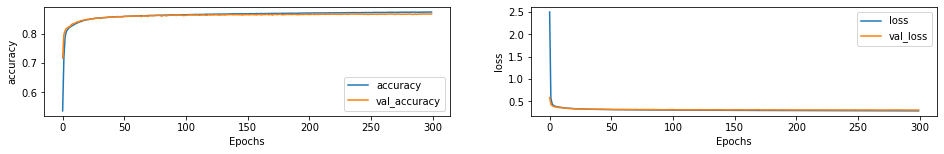

In [13]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

2782/2782 [==============================] - 33s 12ms/step - loss: 0.2937 - accuracy: 0.8735
Test Loss: 0.2936643064022064
Test Accuracy: 0.8734578490257263
              precision    recall  f1-score   support

           0       0.91      0.82      0.87     44509
           1       0.84      0.92      0.88     44489

    accuracy                           0.87     88998
   macro avg       0.88      0.87      0.87     88998
weighted avg       0.88      0.87      0.87     88998

rf auc : 0.9491806910998088


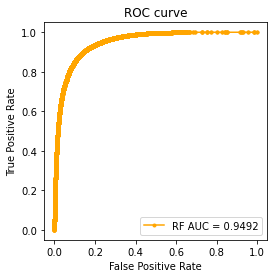

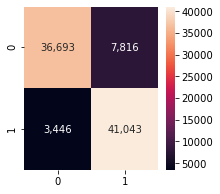

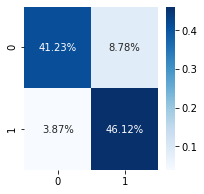

In [14]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

1391/1391 [==============================] - 17s 12ms/step - loss: 0.2923 - accuracy: 0.8750
Test Loss: 0.2922768294811249
Test Accuracy: 0.874985933303833
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     22330
           1       0.86      0.89      0.88     22169

    accuracy                           0.87     44499
   macro avg       0.88      0.88      0.87     44499
weighted avg       0.88      0.87      0.87     44499

rf auc : 0.9469071049435678


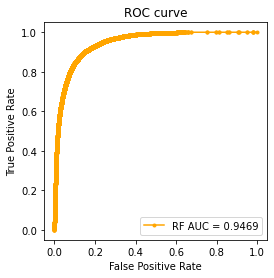

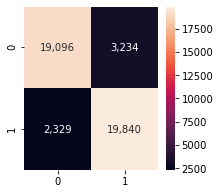

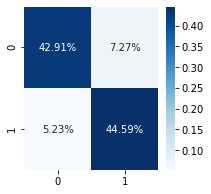

In [14]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

* my : Acc 0.874 AUC 0.946

    * CNN + LSTM : Acc 0.86, AUC 0.943
    * DeepMSpeptide : Acc 0.85 AUC 0.931
    * AP3 : Acc0.83 AUC 0.913
    * PepFormer : Acc 0.869  AUC 0.943